# Advanced Python for Data Science
### DS-GA 1019

### Homework Assignment 04
### Due date: 03/01/2023, 4:00PM
### Student's Name: Ching-Tsung(Deron) Tsai
### Student's e-mail: ct2840@nyu.edu

# Problem 1 (100 points)

The task is to optimize your solutions by using "line_profiler". 

Your submission "spring2023_sol04_yourid.ipynb" will contain:
- the first part is your original solution (a solution that you originally wrote); 
- the second part is your final, optimized solution after using line_profiler; 
- both of which will include the line_profiler results, and your detailed comments.


The problem is to simulate a random motion of $n$ objects over a discrete time. 

Concretely, there is:
- a unit square $[0,1]^2$, 
- $n$ points within the unit square, 
- and the time is discrete $t=0, 1, 2, \dots$. 

At time $t=0$, the positions of $n$ points are randomly and uniformly distributed within the unit square; call these positions $\{p_0, p_1, p_2,\dots, p_{n-1}\}$. 

At every time step $t \geq 0$, every point $i$, chooses to randomly move in one of four directions: left, right, up, down. The distance is also random uniform number on $[0, \delta]$, where $\delta$ is given. 

That is, at every time step $t$ and for every $i$ we generate a random move as: 
$$ p_i := p_i + r_i \cdot u_i$$
where 
$$ r_i \sim uniform[0, \delta],$$ 
and 
$u_i$ represents a random direction, i.e. a randomly chosen vector among $(-1, 0), (1, 0), (0, -1), (0, 1)$.

**Dynamics**

Now, one would like to examine and plot the diagram of the minimum distance $d_{\min}$ among these $n$ points over $T$ iterations.

The task is to complete the rest of this notebook, where definitions of the functions main_orignal and main_optimized are given below. 

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
%load_ext line_profiler

---

### The original code description: 

**TO BE POPULATED**

**EXPLAIN THE SOLUTION** 

---


**Ans**

I use random.uniform function to create the needed parameter values($p_i,r_i,u_i$) and use list comprehension for the updating. Then I brutely compared the distances of all combinations and kept the minimum.

Although we could improve the random steps by replacing the value generation steps and list comprehension to numpy array, the single line profiler shows that finding the shortest distance took the longest time. I will focus on optimizing the part of getting the minimum distance within the step

In [22]:
from itertools import combinations
def min_distance(x_cur,y_cur,n):
    """
    x_cur: a list of x-axis value
    y_cur: a list of y-axis value
    return: float, the min distances among all points
    """
    output = float('inf')
    for idx1,idx2 in combinations(range(n),2):
        distance_sq = (x_cur[idx1]-x_cur[idx2])**2 + (y_cur[idx1]-y_cur[idx2])**2
        if distance_sq < output:
            output = distance_sq
    return output**0.5
def main_original(n, delta, T): 
    """ 
    n: is the number of uniformly at random generated points in the unit square 
    delta: a maximal move of a point in one of four random directions: left, right, up, or down 
    T: number of iterations
    return: 
    lst_of_min_distances: of the minimum distances among all n points over times: t=0, 1, 2, \dots, T - 1,
    it is a list of reals of length T"""
    lst_of_min_distances = []
    # create n random points within square:
    x_cur = [random.uniform(0,1) for _ in range(n)]
    y_cur = [random.uniform(0,1) for _ in range(n)]
    for i in range(T):
        # create ri
        ri = [random.uniform(0,delta) for _ in range(n)]
        # create ui
        ui = [random.choice(((-1,0),(1,0),(0,-1),(0,1))) for _ in range(n)]
        
        # update:
        x_cur = list(map(lambda x,r,u: min(1,max(x+r*u[0],0)),x_cur,ri,ui))
        y_cur = list(map(lambda y,r,u:min(1,max(y+r*u[1],0)),y_cur,ri,ui))
        cur_min = min_distance(x_cur,y_cur,n)
        lst_of_min_distances.append(cur_min)
    return lst_of_min_distances

In [23]:
n = 1500
delta = 1.0 / n
T = 40           

In [24]:
%lprun -f main_original lst_min_dist = main_original(n, delta, T)

len: 40


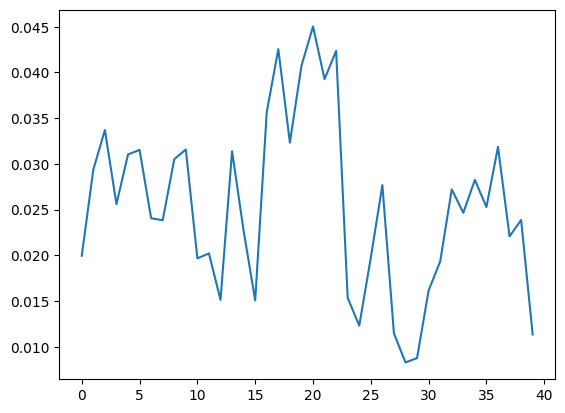

In [25]:
# plot the diagram of the minimum distances:
# where we rescale distance with by factor $\sqrt{n}$:
print("len:", len(lst_min_dist))
plt.plot(range(T), np.array(lst_min_dist) * np.sqrt(n))
plt.show()

---

### The optimized code description: 

** TO BE POPULATED **

** EXPLAIN THE SOLUTION ** 

---


**Ans**

According to the line profiler, finding the min distance took the longest time for the main function. I decided to use numpy array instead of list to replace the loop with element-wise substraction.

My main modifications are:

- turn all list comprehension into numpy operation

- use numpy.random to create n random numbers at once. (Originally use random and list comprehension)

- use numpy array broadcasting to create pairwise subtraction of all the points, and subsequently find the min distance within the array. The details are in the notes of function min_distance_np

- use yield instead of return to save memory

The function was speed up for more than 6 times. Although the line_profiler shows that the function still spent most of time in calculating min distance.

In [19]:
def min_distance_np(p_cur,n):
    """
    p_cur: a n*2 numpy array, col0 is the x-axis, col1 is the y-axis
    y_cur: a list of y-axis value
    return: float, the min distances among all points
    """
    all_dist = p_cur - p_cur.reshape(n,1,2) # prepend: n,2 -> 1,n,2
    # > (1,n,2) - (n,1,2) = (n,n,2) == z,row,col
    all_dist = np.sum(all_dist**2,axis=2)        # get the sum of x+y axis
    #all_dist.diagonal()[:] = float("inf")  # failed, read-only mode
    np.fill_diagonal(all_dist,float("inf")) # because diagonal are the distance of point to itself, use inf to replace 0
    output = np.sqrt(np.min(all_dist))
    return output

def main_optimized(n, delta, T): 
    """ 
    n: is the number of uniformly at random generated points in the unit square 
    delta: a maximal move of a point in one of four random directions: left, right, up, or down 
    T: number of iterations
    return: 
    lst_of_min_distances: of the minimum distances among all n points over times: t=0, 1, 2, \dots, T - 1,
    it is a list of reals of length T"""
    lst_of_min_distances = []
    u_src = np.array(((-1,0),(1,0),(0,-1),(0,1))) # source for ui generation
    # starting point
    p_cur = np.random.uniform(0,1,2*n).reshape(n,2)
    for i in range(T):
        # create ri
        ri = np.random.uniform(0,delta,n)
        # create ui
        ui_idx = np.random.choice(4, size=n, replace=True)
        ui = u_src[ui_idx, :]
        # update:
        p_cur[:,0] += ri*ui[:,0] 
        p_cur[:,1] += ri*ui[:,1] 
        p_cur = np.clip(p_cur, 0, 1)   # turn val > 1 to 1 & val < 0 to 0
        yield min_distance_np(p_cur,n)
        #lst_of_min_distances.append(cur_min)
    #return lst_of_min_distances 

In [20]:
n=1500
delta = 1.0 / n
T = 40
len(lst_min_dist)

40

In [21]:
%lprun -f main_optimized lst_min_dist = list(main_optimized(n, delta, T))

len: 40


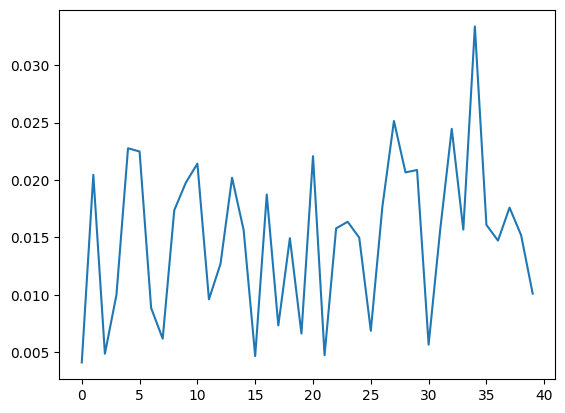

In [22]:
# plot the diagram of the minimum distances:
# where we rescale distance by a factor $\sqrt{n}$:
print("len:", len(lst_min_dist))
plt.plot(range(T), np.array(lst_min_dist) * np.sqrt(n)) 
plt.show()